# Statistical arbitrage using CAC40 eigen portfolios

Implementing ideas taken from "Statistical Arbitrage in the U.S. Equities Market" by Avellaneda & Lee (https://dx.doi.org/10.2139/ssrn.1153505)

... This work is in progress ...

[CAC40 index](#index)  
[CAC40 stocks returns correlations](#rets)  
[Linear transform of returns using eigenvectors of the correlation matrix](#transform)  
[CAC40 eigen portfolios](#eigen)  

[Trading strategy using eigen portfolios as factors](#strat)
- [Trading strategy example : market-correlated stock](#strat1)  
- [Trading strategy example : market-decorrelated stock](#strat2)  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormap
import seaborn as sns

import numpy as np
import pandas as pd
import pickle

from finance_utils import *
import yfinance as yf

from sklearn import linear_model as lm

### CAC40 index data  <a id='index'></a>

From `1_CAC40_data.ipynb` notebook

In [2]:
df_cac40 = pd.read_pickle('./cac40_data/df_cac40.pkl')

with open('./cac40_data/isin2ticker.pkl', 'rb') as f:
    isin2ticker = pickle.load(f)
all_tickers = ' '.join([x for x in isin2ticker.values()])

# put both dataframes in the same range of dates
df_cac40_stocks = pd.read_pickle('./cac40_data/df_cac40_stocks.pkl')
df_cac40 = df_cac40.loc[df_cac40_stocks.index.normalize()[0]:df_cac40_stocks.index.normalize()[-1]].copy()

In [3]:
set(df_cac40_stocks.index) - set(df_cac40.index)

{Timestamp('2022-04-18 00:00:00'),
 Timestamp('2023-04-10 00:00:00'),
 Timestamp('2023-05-01 00:00:00')}

In [4]:
df_cac40_stocks.drop(['2022-04-18', '2023-04-10', '2023-05-01'], inplace=True)

### CAC40 stocks returns correlations  <a id='rets'></a>

In [5]:
rets = df_cac40_stocks.pct_change().dropna()
# normalized returns
normed_rets = (rets - rets.mean())/rets.std()

- Let $\textbf{X} \in \mathbb{R}^{p\times N}$ the matrix of returns of $p$ stocks during $N$ days.  

- Its empirical correlation matrix is: $$\textbf{C}_{X}=\frac{1}{N-1}\textbf{X}^{T}\textbf{X}$$ and shows the assets are strongly correlated:

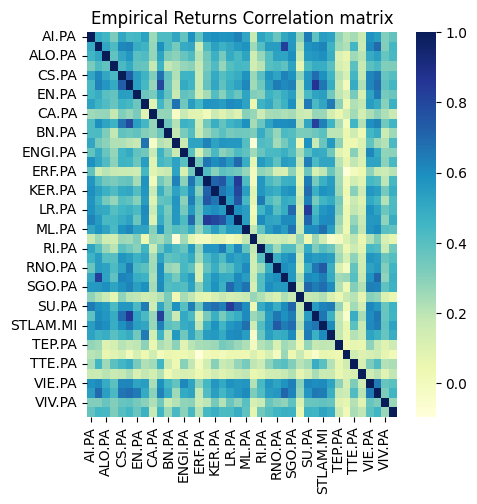

In [6]:
plt.figure(figsize = (5,5))
plt.title('Empirical Returns Correlation matrix')
_ = sns.heatmap(rets.corr(), cmap="YlGnBu")

The eigenvalue decomposition of $\textbf{C}_{X}$ is (assuming $N\geq p$): $$\textbf{C}_{X} = \textbf{U}\textbf{$\Lambda$}\textbf{U}^{T}$$ $\textbf{C}_{X}$ is real and symetric, so $\textbf{U}$ the matrix of eigenvectors is orthogonal. $\textbf{$\Lambda$}$ is the diagonal matrix of eigenvalues $\lambda_i$.

The trace of $\textbf{C}_{X}$ represents the total variation of data $\textbf{X}$. Because the trace is invariant by a permutation of its arguments:

$$Tr(\textbf{C}_{X})= Tr(\textbf{U}\textbf{$\Lambda$}\textbf{U}^{T}) = Tr(\textbf{$\Lambda$}\textbf{U}^{T}\textbf{U})=Tr(\textbf{$\Lambda$})$$


### Linear transform of returns using eigenvectors of the correlation matrix <a id='transform'></a>

The idea is to look for linear combinations of stocks returns that would make the correlation matrix diagonal. Different linear combinations of stocks returns can produce uncorrelated portfolios.


- Let $\textbf{Z}=\textbf{X}\textbf{V}$ the linear transform of matrix $\textbf{X}\in \mathbb{R}^{p\times k}$, where $\textbf{V}$ is an orthogonal matrix and $p \leq k$:
$$\textbf{Z}=\textbf{X}\textbf{V}$$

- The empirical correlation matrix of $\textbf{Z}$ is: $$\textbf{C}_{Z}=\frac{1}{N-1}\textbf{Z}^{T}\textbf{Z}=\frac{1}{N-1}\textbf{V}^{T}\textbf{X}^{T}\textbf{X}\textbf{V}=\textbf{V}^{T}\textbf{C}_{X}\textbf{V}=\textbf{V}^{T}\textbf{U}\textbf{$\Lambda$}\textbf{U}^{T}\textbf{V}$$ and if $k=p$, then $\textbf{U}=\textbf{V}$ and $\textbf{C}_{Z}=\textbf{$\Lambda$}$.


- Since $\textbf{$\Lambda$}$ is diagonal, then $\textbf{Z}$ is made of uncorrelated components. Moreover:
$$Tr(\textbf{C}_{Z}) = Tr(\textbf{$\Lambda$}) = Tr(\textbf{C}_{X})$$ so encoding $\textbf{X}$ through the linear transform $\textbf{Z}=\textbf{X}\textbf{V}=\textbf{X}\textbf{U}$ preserves the total variation of data. 

The columns of linear transform $\textbf{Z}$ are then returns multiplied by the of eigenvectors of $\textbf{C}_{X}$, **these eigenvectors can be interpreted as weights on stocks**.

In [7]:
# eigenvalue decomposition of correlation matrix
eigenvalues, eigenvectors = np.linalg.eig(normed_rets.corr())

# divide eigenvectors by their lengths so that they sum to 1 and act as weights
linear_transform = np.matmul(rets, eigenvectors/eigenvectors.sum(axis=0))

**Multiplying returns data by the orthogonal matrix of eigenvectors cleans the correlation matrix**  
The empirical correlation matrix of linear transform $\textbf{Z}$ is diagonal, with some noise added:

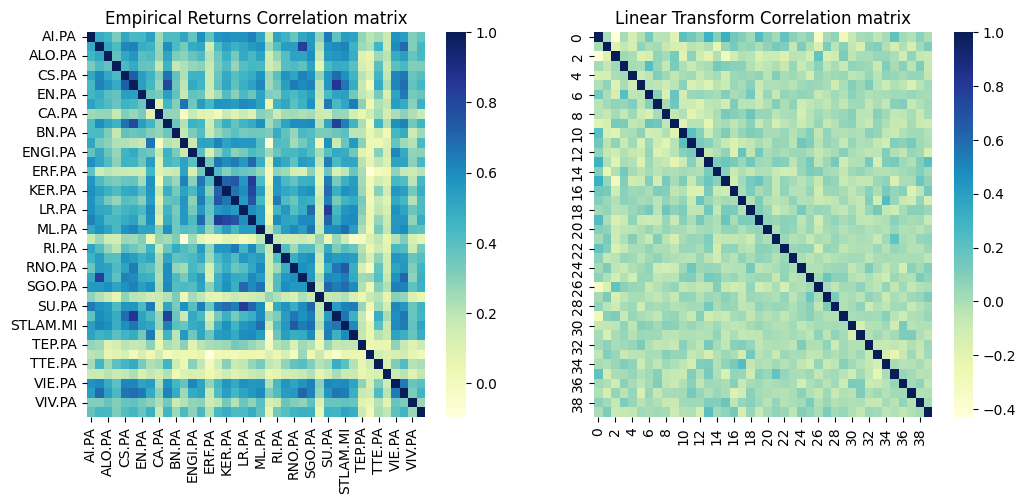

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.title.set_text('Empirical Returns Correlation matrix')
ax2.title.set_text('Linear Transform Correlation matrix')
sns.heatmap(rets.corr(), cmap="YlGnBu", ax=ax1)
sns.heatmap(linear_transform.corr(), cmap="YlGnBu", ax=ax2)
plt.show()

**Density of states of eigenvalues identifies noise from signal**

noise in the bulk spectrum on the left, market mode on the right, other orthogonal portfolios in the middle

**TODO**: filter out noise using Random Matrix theory

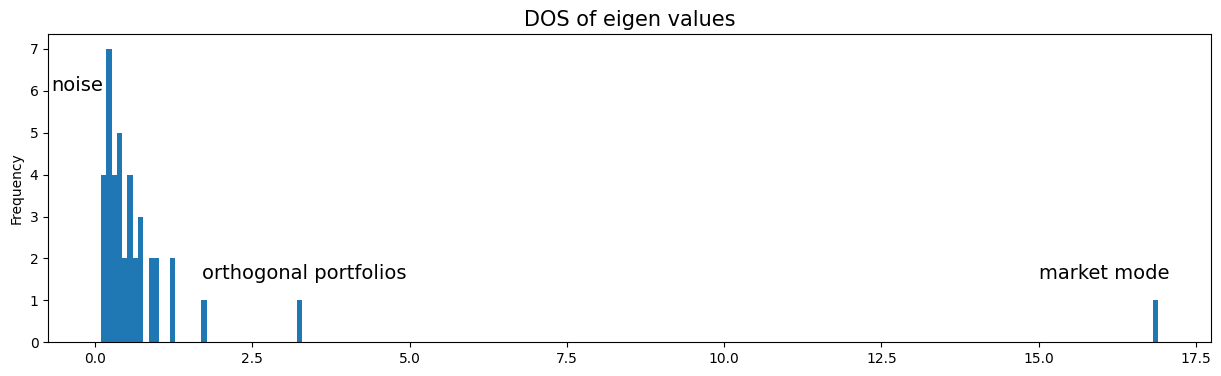

In [9]:
fig,ax = plt.subplots(figsize=(15,4))
ax.set_title('DOS of eigen values', fontsize=15)
#ax.set_xlabel('Date')
ax.text(-0.7, 6, r'noise', fontsize=14)
ax.text(1.7, 1.5, r'orthogonal portfolios', fontsize=14)
ax.text(15, 1.5, r'market mode', fontsize=14)
pd.Series(eigenvalues).plot.hist(bins=200, figsize=(15,4))
plt.show()

=> eigenportfolios with largest eigenvalues can be used as predictor in a factor model

### CAC40 eigen portfolios  <a id='eigen'></a>

Sorting eigenvectors according to corresponding sorted eigenvalues

In [10]:
sorted_eigenvals = np.squeeze(pd.DataFrame({'eigenvalues':eigenvalues}).sort_values(by='eigenvalues', ascending=False).values)
sorted_eigenvals_idx = pd.DataFrame({'eigenvalues':eigenvalues}).sort_values(by='eigenvalues', ascending=False).index

In [11]:
sorted_eigenvectors = pd.DataFrame(eigenvectors).T.loc[sorted_eigenvals_idx].T
sorted_eigenvectors.set_index(rets.columns, inplace=True)
sorted_eigenvectors.head()

,0,1,2,3,4,5,6,7,8,9,...,30,29,28,27,26,25,23,22,20,14
AI.PA,-0.176460,0.109933,-0.193593,-0.168161,0.042980,-0.077859,-0.004521,0.015437,-0.031095,0.064535,...,0.193366,-0.192900,0.120927,-0.167067,-0.095358,0.007244,0.086050,-0.002237,-0.083724,-0.059207
AIR.PA,-0.187543,-0.108878,-0.073255,-0.026565,-0.220962,0.152250,-0.064363,-0.064080,0.072740,0.005915,...,0.097533,0.136266,0.095416,0.120141,-0.223821,0.091034,0.489187,-0.271830,0.152792,0.114381
ALO.PA,-0.162516,-0.080578,0.131429,-0.079423,0.087059,-0.202608,-0.064953,-0.064471,0.215441,0.176158,...,0.030541,-0.100178,0.007313,0.047042,0.013081,0.073472,0.010135,0.011246,0.040544,-0.008765
MT,-0.136831,-0.084504,0.190840,-0.114146,-0.037454,0.020721,0.042183,-0.027922,-0.434869,-0.046708,...,-0.065424,-0.033469,-0.022377,-0.030334,0.000067,0.001238,-0.041433,0.010187,-0.058618,0.013339
CS.PA,-0.183564,-0.164009,-0.024087,0.012188,-0.004590,0.078242,0.029353,0.088853,-0.046354,0.012025,...,-0.150379,0.179225,-0.072378,0.093890,0.216518,0.040169,0.102469,-0.067112,0.053999,-0.073656


#### 1st eigen portfolio

[Avellaneda&Lee 2009]  
"As pointed out by several authors (see for instance, Laloux et al.(2000)), **the
dominant eigenvector is associated with the “market portfolio”**, in the sense 
that all the coefficients v i , i = 1, 2.., N are positive. Thus, the eigenport-
folio has positive weights. We notice that these weights are in-
versely proportional to the stock’s volatility. This weighting is consistent with
the capitalization-weighting, since larger capitalization companies tend to have
smaller volatilities."

In [12]:
eigenportfolio_idx = 0

<Axes: title={'center': '1st eigenportfolio weights, sorted'}>

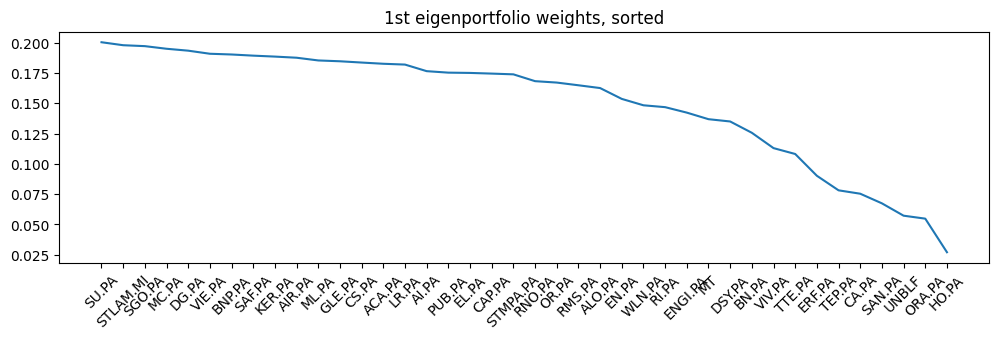

In [13]:
# 1st eigenvector has negative components, but eigenvectors are only unique up to a sign
np.abs(sorted_eigenvectors[eigenportfolio_idx]).sort_values(ascending=False).plot(title='1st eigenportfolio weights, sorted',
                                                            figsize=(12,3),
                                                            xticks=range(0, len(rets.columns),1),
                                                            rot=45)

Respective amounts invested in each of the stocks $Q^{(j)}_i = v^{(j)}_i / \sigma_i$, used to calculate return of an eigen portfolio

In [14]:
Q = sorted_eigenvectors/rets.std().values
Q = Q/Q.sum(axis=0)

In [15]:
eigenportfolio_rets = pd.Series(np.matmul(rets.values, Q[eigenportfolio_idx]))

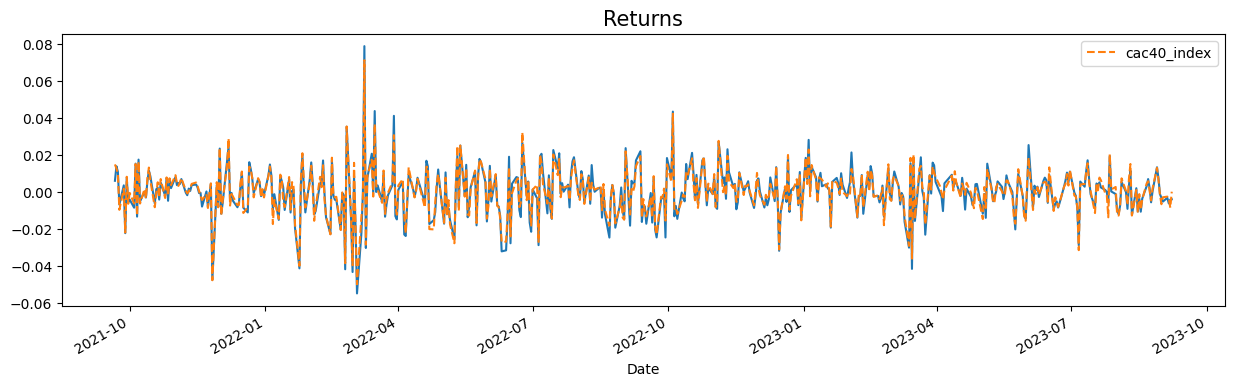

In [16]:
fig,ax = plt.subplots(figsize=(15,4))
ax.set_title('Returns', fontsize=15)
ax.set_xlabel('Date')
pd.DataFrame(eigenportfolio_rets).set_index(rets.index)[0].plot.line(ax=ax, 
              linewidth= 1.5, linestyle='-')
df_cac40.pct_change().dropna().plot.line(ax=ax, linewidth= 1.5, linestyle='--')
plt.show()

Wealth index of 1st eigenportfolio shows high correlation to market (represented here by CAC40 index)

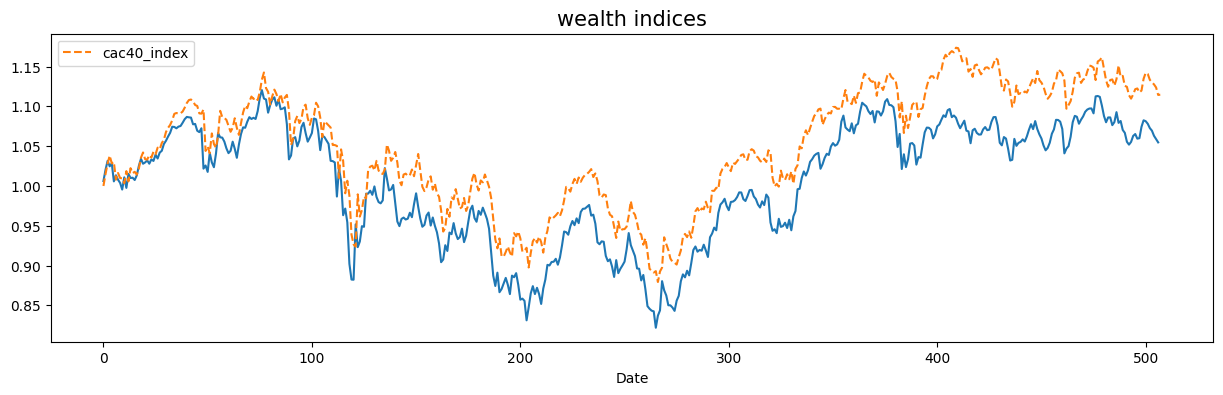

In [17]:
fig,ax = plt.subplots(figsize=(15,4))
ax.set_title('wealth indices', fontsize=15)
ax.set_xlabel('Date')
(1 + eigenportfolio_rets).cumprod().plot(ax=ax)
(df_cac40/df_cac40.iloc[0].values[0]).reset_index(drop=True).plot.line(ax=ax, linewidth= 1.5, linestyle='--')
plt.show()

In [18]:
pd.concat([pd.DataFrame(eigenportfolio_rets).set_index(rets.index), df_cac40.pct_change().dropna()], axis=1).corr()

,0,cac40_index
0,1.000000,0.976657
cac40_index,0.976657,1.000000


#### 2nd eigen portfolio

[Avellaneda&Lee 2009]  
"In this new ordering, we notice that the “neighbors” of a particular company tend to be in the same
industry group. This property, which we call coherence, holds true for v(2)
and for other high-ranking eigenvectors. As we descend in the spectrum towards
the noise eigenvectors, the property that nearby coefficients correspond to firms
in the same industry is less true and coherence will not hold for eigenvectors of
the noise spectrum"

<Axes: title={'center': '2nd eigenportfolio weights, sorted'}>

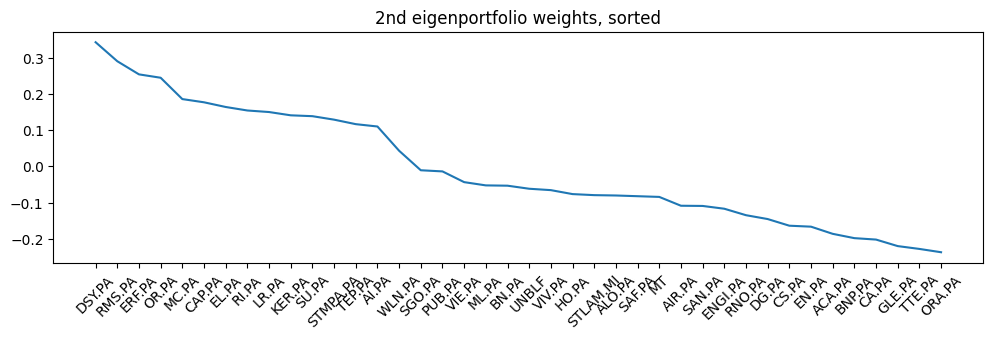

In [19]:
(sorted_eigenvectors[1]).sort_values(ascending=False).plot(title='2nd eigenportfolio weights, sorted',
                                                            figsize=(12,3),
                                                            xticks=range(0, len(rets.columns),1),
                                                            rot=45)

[Avellaneda&Lee 2009]  
"The eigenportfolios can therefore be interpreted as long-short portfolios at the level of industries or sectors"

... paper was refering to SP500, but here CAC40 has only 40 stocks (French stock exchange). This does not hold here.

In [20]:
ticker2name = {k:v for (k,v) in zip((-sorted_eigenvectors[1]).sort_values(ascending=False).index,
                                    [yf.Ticker(s).info['shortName'] 
                                     for s in (-sorted_eigenvectors[0]).sort_values(ascending=False).index]
                                   )}

In [21]:
[ticker2name[x] for x in (sorted_eigenvectors[1]).sort_values(ascending=False).index]

['THALES',
 'ORANGE',
 'UNIBAIL-RODAMCO-WESTFIELD',
 'SANOFI',
 'CARREFOUR',
 'TELEPERFORMANCE',
 'EUROFINS SCIENT.',
 'TOTALENERGIES',
 'VIVENDI SE',
 'DANONE',
 'DASSAULT SYSTEMES',
 'Arcelor Mittal NY Registry Shar',
 'ENGIE',
 'PERNOD RICARD',
 'WORLDLINE',
 'BOUYGUES',
 'ALSTOM',
 'HERMES INTL',
 "L'OREAL",
 'RENAULT',
 'STMICROELECTRONICS',
 'CAPGEMINI',
 'ESSILORLUXOTTICA',
 'PUBLICIS GROUPE SA',
 'AIR LIQUIDE',
 'LEGRAND',
 'CREDIT AGRICOLE',
 'AXA',
 'SOCIETE GENERALE',
 'MICHELIN',
 'AIRBUS SE',
 'KERING',
 'SAFRAN',
 'BNP PARIBAS ACT.A',
 'VEOLIA ENVIRON.',
 'VINCI',
 'LVMH',
 'SAINT GOBAIN',
 'STELLANTIS',
 'SCHNEIDER ELECTRIC SE']

<Axes: title={'center': '3rd eigenportfolio weights, sorted'}>

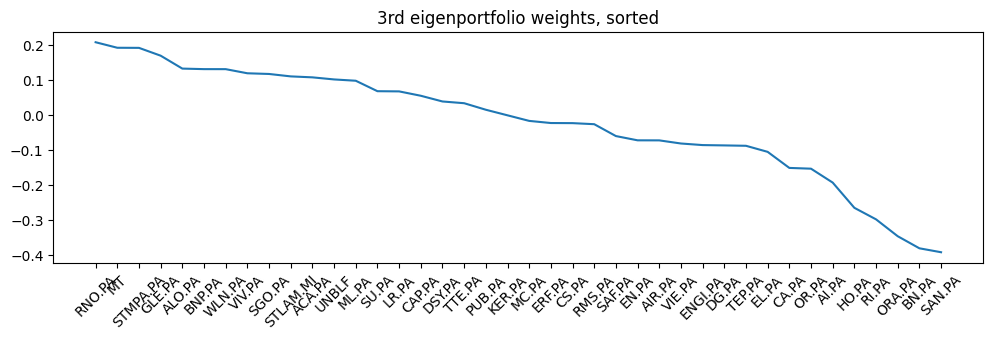

In [22]:
(sorted_eigenvectors[2]).sort_values(ascending=False).plot(title='3rd eigenportfolio weights, sorted',
                                                            figsize=(12,3),
                                                            xticks=range(0, len(rets.columns),1),
                                                            rot=45)

### Trading strategy using eigen portfolios as factors  <a id='strat'></a>

Regressing a stock return series on eigenportfolios:  
$$\frac{dS_i(t)}{S_i(t)} = \sum_{j=1}^{N}\beta_{ij}\frac{dI_j(t)}{I_j(t)} + d\tilde X_i(t)$$

Linear regression is used to get factors $\sum_{j=1}^{N}\beta_{ij}\frac{dI_j(t)}{I_j(t)}$, and substracting prediction from return data gives idiosyncratic component for stock $i$ : $d\tilde X_i(t)$

In [23]:
def get_residual_signal(stock, n_factors=3):
    
    # linear regression can be done on up to 3 eigen portfolios as factors
    eigenportfolio_rets_0 = pd.Series(np.matmul(rets.values, Q[0]))
    eigenportfolio_rets_1 = pd.Series(np.matmul(rets.values, Q[1]))
    eigenportfolio_rets_2 = pd.Series(np.matmul(rets.values, Q[2]))

    X = rets[stock].values
    y = eigenportfolio_rets.values

    if n_factors == 1: factors = np.array([eigenportfolio_rets_0]).T
    if n_factors == 2: factors = np.array([eigenportfolio_rets_0, eigenportfolio_rets_1]).T
    if n_factors == 3: factors = np.array([eigenportfolio_rets_0, eigenportfolio_rets_1, eigenportfolio_rets_2]).T

    reg = lm.LinearRegression().fit(factors, X)
    residuals = rets[stock].values - reg.predict(factors)
    
    return factors, reg, residuals

**Trading signal**, based on mean-reversion of residuals :

Trading occurs when s-score $(\tilde X_i(t) - m_i)/(\sigma_i\sqrt{\tau_i/2})$ goes beyond thresholds

In [24]:
def trading_signal(residuals):
    # mean reversion time taken from Avellaneda&Lee on SP500 is 8.4
    # here kappa_i arbitrarily lowered 4 to produce trading signal, but should be estimated yet for CAC40 data
    kappa_i = 4 # = 1/tau inverse reversion time constant

    # thresholds for trading, identical to Avellaneda&Lee
    sbo = 1.25 # buy to open
    sso = 1.25 # sell to open
    sbc = 0.75 # close short position
    ssc = 0.5 # close long position

    # parameters of s-score estimated over a rolling window of 60 days
    df_residuals = pd.DataFrame({'residuals':residuals}, index=rets.index)
    df_residuals['m_i'] = df_residuals.rolling(60).mean()
    df_residuals['sigma_equilibrium'] = rets[stock].rolling(60).std()/2*kappa_i
    df_residuals['s_score'] = (df_residuals['residuals'] - df_residuals['m_i'])/df_residuals['sigma_equilibrium']

    fig,ax = plt.subplots(figsize=(15,7))
    ax.axhline(sso, c='r', linestyle='dotted', label='sell to open')
    ax.axhline(sbc, c='orange', linestyle='dotted', label='close short')
    ax.axhline(-ssc, c='lightgreen', linestyle='dotted', label='close long')
    ax.axhline(-sbo, c='g', linestyle='dotted', label='buy to open')
    ax = df_residuals['s_score'].dropna().plot()
    ax.legend()

### Trading strategy examples : market-correlated stock  <a id='strat1'></a>

Choosing a stock among the ones with high correlation to the market

In [64]:
pd.concat([df_cac40.pct_change().dropna(), rets], axis=1).corr()['cac40_index'].sort_values(ascending=False).head()

cac40_index    1.000000
MC.PA          0.858676
SU.PA          0.820127
KER.PA         0.796764
SAF.PA         0.777342
Name: cac40_index, dtype: float64

In [102]:
stock = 'MC.PA'

In [106]:
factors, reg, residuals = get_residual_signal(stock)

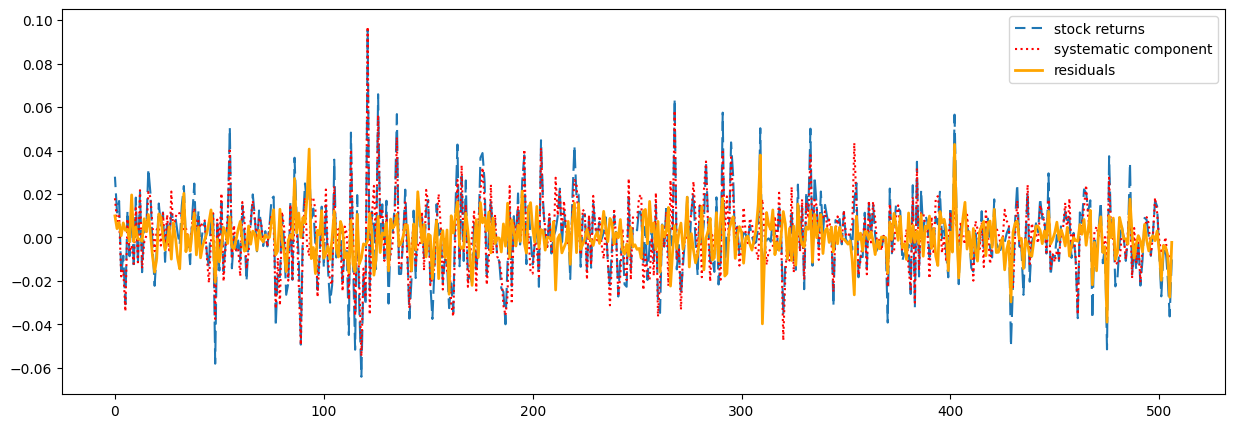

In [107]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(rets[stock].values, linestyle=(5, (10, 3)), label='stock returns')
plt.plot(reg.predict(factors), linestyle='dotted', color='red', label='systematic component')
plt.plot(residuals, color='orange', linewidth= 2, label='residuals')
#plt.xlim(100,200)
plt.legend()

**s-score** is built from orange residuals signal:

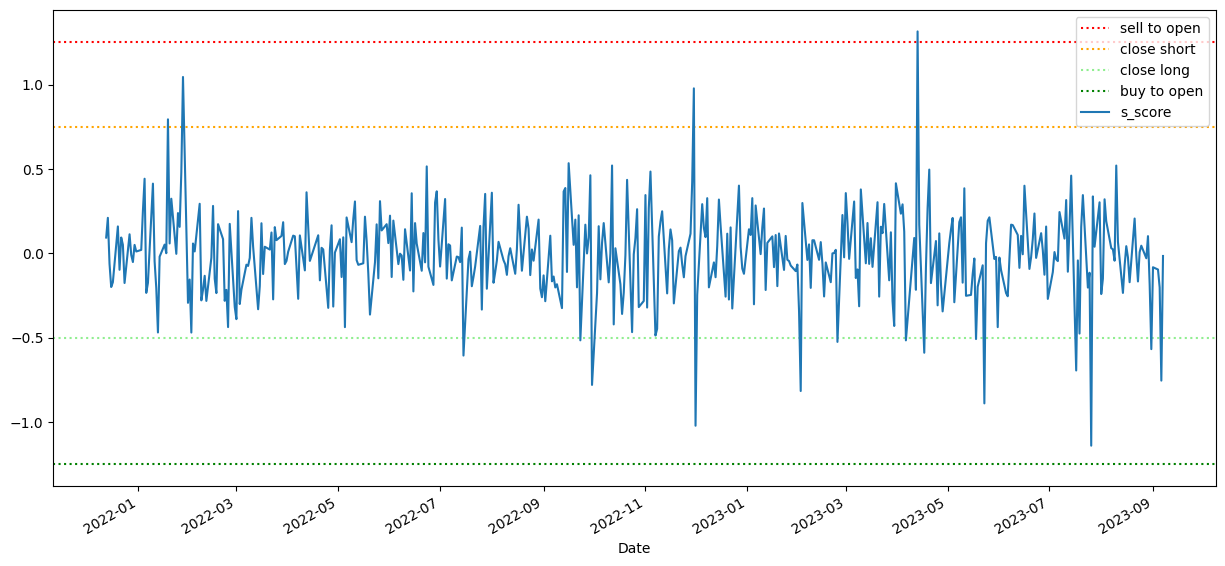

In [108]:
trading_signal(residuals)

**=> few, if any trading signal** here because of high correlation to market (given the considered thresholds)

### Trading strategy example : market-decorrelated stock  <a id='strat2'></a>

Choosing a stock among the ones with low correlation to the market

In [109]:
pd.concat([df_cac40.pct_change().dropna(), rets], axis=1).corr()['cac40_index'].sort_values(ascending=False).tail()

TEP.PA    0.324054
CA.PA     0.273580
ORA.PA    0.212387
UNBLF     0.212209
HO.PA     0.134037
Name: cac40_index, dtype: float64

In [113]:
stock = 'UNBLF'

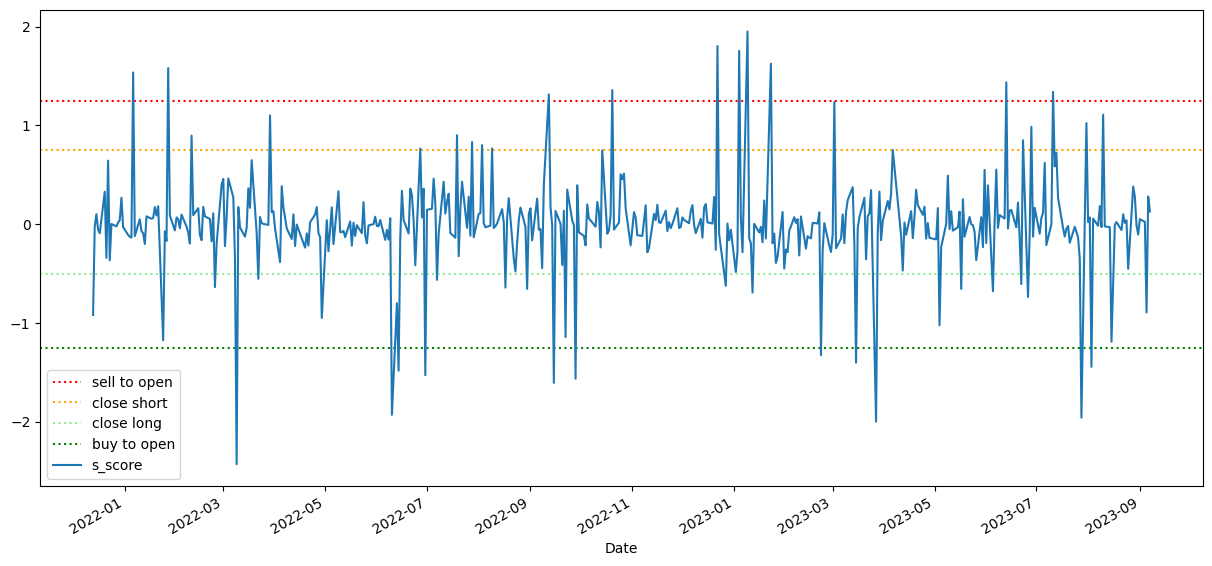

In [114]:
factors, reg, residuals = get_residual_signal(stock)
trading_signal(residuals)

**=> more trading opportunities from an uncorrelated stock**

Somewhat stronger signal when regressing on fewer factors:  
(but needs more investigation)

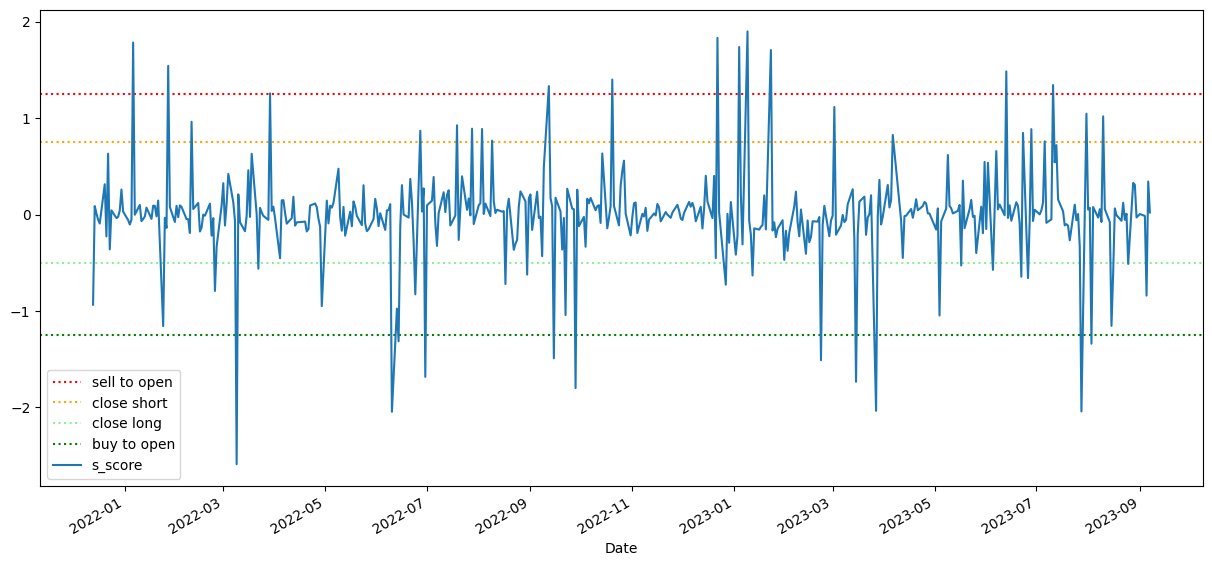

In [115]:
factors, reg, residuals = get_residual_signal(stock, n_factors=1)
trading_signal(residuals)